In [51]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


   store_underage_cost Architecture Class  Train Loss    Dev Loss  # of runs                                                                                                                                                                                                                                              path omit_context_from_store_input  Dev Gap %
0                    2                GNN -107.264461  -94.806152         15    /user/ml4723/Prj/NIC/ray_results/warehouse_real/GNN_softplus/30/run_2024-11-08_00-28-32/run_4b73c_00010_10_apply_normalization=False,learning_rate=0.0010,omit_context_from_store_input=False,samples=4,store_orders_for_w_2024-11-08_00-28-33                         False  31.349753
0                    2       Just_In_Time -152.204474 -138.100234          1                                                               /user/ml4723/Prj/NIC/ray_results/warehouse_real/just_in_time/30/run_2024-11-07_01-26-12/run_2f29c_00000_0_samples=1,store_underage_cost=2,war

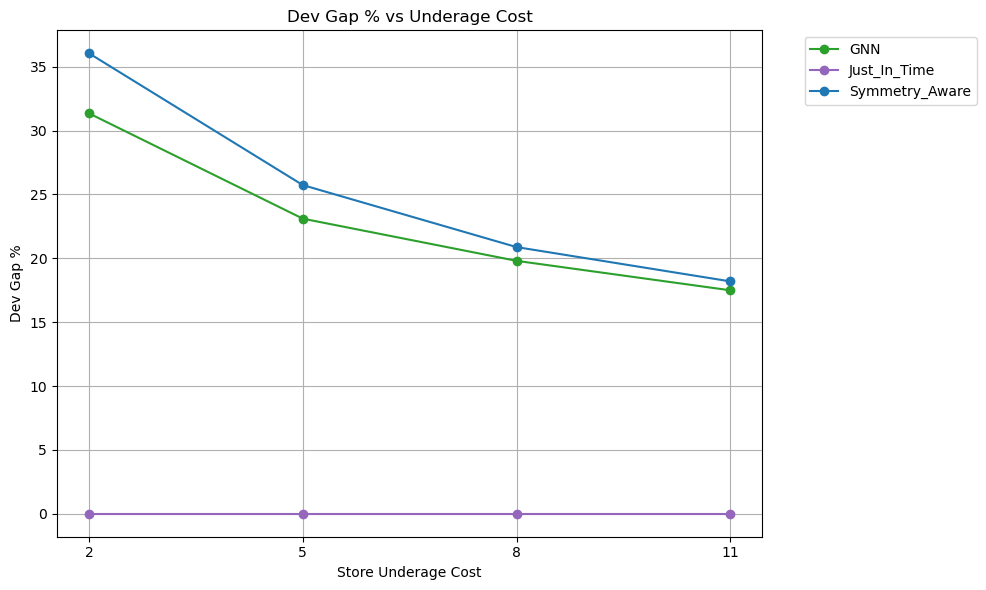

In [52]:
# Define color scheme for architecture types
color_scheme = {
    "Just_In_Time": "#9467bd",  # Purple
    "Symmetry_Aware": "#1f77b4",  # Blue solid
    "GNN": "#2ca02c",  # Green solid
}

linestyle_scheme = {
    "Just_In_Time": "-",
    "Symmetry_Aware": "-", 
    "GNN": "-"
}

real_path = 'warehouse_real'
n_stores = 30 # 1 3 10 30 46
just_in_time_paths = {
    n_stores: f'/user/ml4723/Prj/NIC/ray_results/{real_path}/just_in_time/{n_stores}',
}
symmetry_aware_paths = {
    n_stores: f'/user/ml4723/Prj/NIC/ray_results/{real_path}/symmetry_aware/{n_stores}',
}
gnn_paths = {
    n_stores: f'/user/ml4723/Prj/NIC/ray_results/{real_path}/GNN_softplus/{n_stores}',
}

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    if condition_name == 'omit_context_from_store_input':
        return False
    return None

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'

store_underage_cost = [2, 5, 8, 11]
results_interpretor = rri.RayResultsinterpreter()

# Just in time
df_just_in_time = results_interpretor.make_table(just_in_time_paths, {'store_underage_cost': store_underage_cost}, default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_just_in_time.insert(1, 'Architecture Class', "Just_In_Time")
df_just_in_time.insert(1, 'hyperparam_name', "just_in_time_real")

# Symmetry Aware
df_symmetry_aware = results_interpretor.make_table(symmetry_aware_paths, 
    {'store_underage_cost': store_underage_cost, 'apply_normalization': [False], 'store_orders_for_warehouse': [False], 'omit_context_from_store_input': [False]}, 
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_symmetry_aware.insert(1, 'Architecture Class', "Symmetry_Aware")
df_symmetry_aware.insert(1, 'hyperparam_name', "symmetry_aware_real")

# GNN
df_gnn = results_interpretor.make_table(gnn_paths, 
    {'store_underage_cost': store_underage_cost, 'apply_normalization': [False], 'store_orders_for_warehouse': [False], 'omit_context_from_store_input': [False]}, 
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn.insert(1, 'Architecture Class', "GNN")
df_gnn.insert(1, 'hyperparam_name', "GNN_real")

# Combine all dataframes
df = pd.concat([
    df_just_in_time,
    df_symmetry_aware,
    df_gnn
])

min_dev_loss = df.groupby(['store_underage_cost'])['Dev Loss'].transform('min')
df['Dev Gap %'] = -((df['Dev Loss'] - min_dev_loss) / min_dev_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Dev Gap %', df.pop('Dev Gap %'))
df.drop(columns=['# of stores'], inplace=True)
df.sort_values(by=['store_underage_cost', 'Architecture Class'], inplace=True)
cols = df.columns.tolist()
cols.remove('store_underage_cost')
cols = ['store_underage_cost'] + cols
df = df[cols]

df_to_print = df.copy()
df_to_print.drop(columns=['hyperparam_name', 'Learning Rate', 'apply_normalization', 'store_orders_for_warehouse'], inplace=True)
# Calculate overfitting metric (difference between train and dev loss)

print(df_to_print.to_string())
# Create the plot for fixed case
fig, ax = plt.subplots(figsize=(10, 6))

# Plot for Dev Gap %
pivot_df_fixed_dev = df.pivot(index='store_underage_cost', columns='Architecture Class', values='Dev Gap %')
for column in pivot_df_fixed_dev.columns:
    ax.plot(pivot_df_fixed_dev.index, pivot_df_fixed_dev[column], 
            marker='o', 
            label=column, 
            color=color_scheme[column],
            linestyle=linestyle_scheme[column])

ax.set_xlabel('Store Underage Cost')
ax.set_ylabel('Dev Gap %')
ax.set_title('Dev Gap % vs Underage Cost')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True)
ax.set_xticks(pivot_df_fixed_dev.index)

plt.tight_layout()
plt.show()

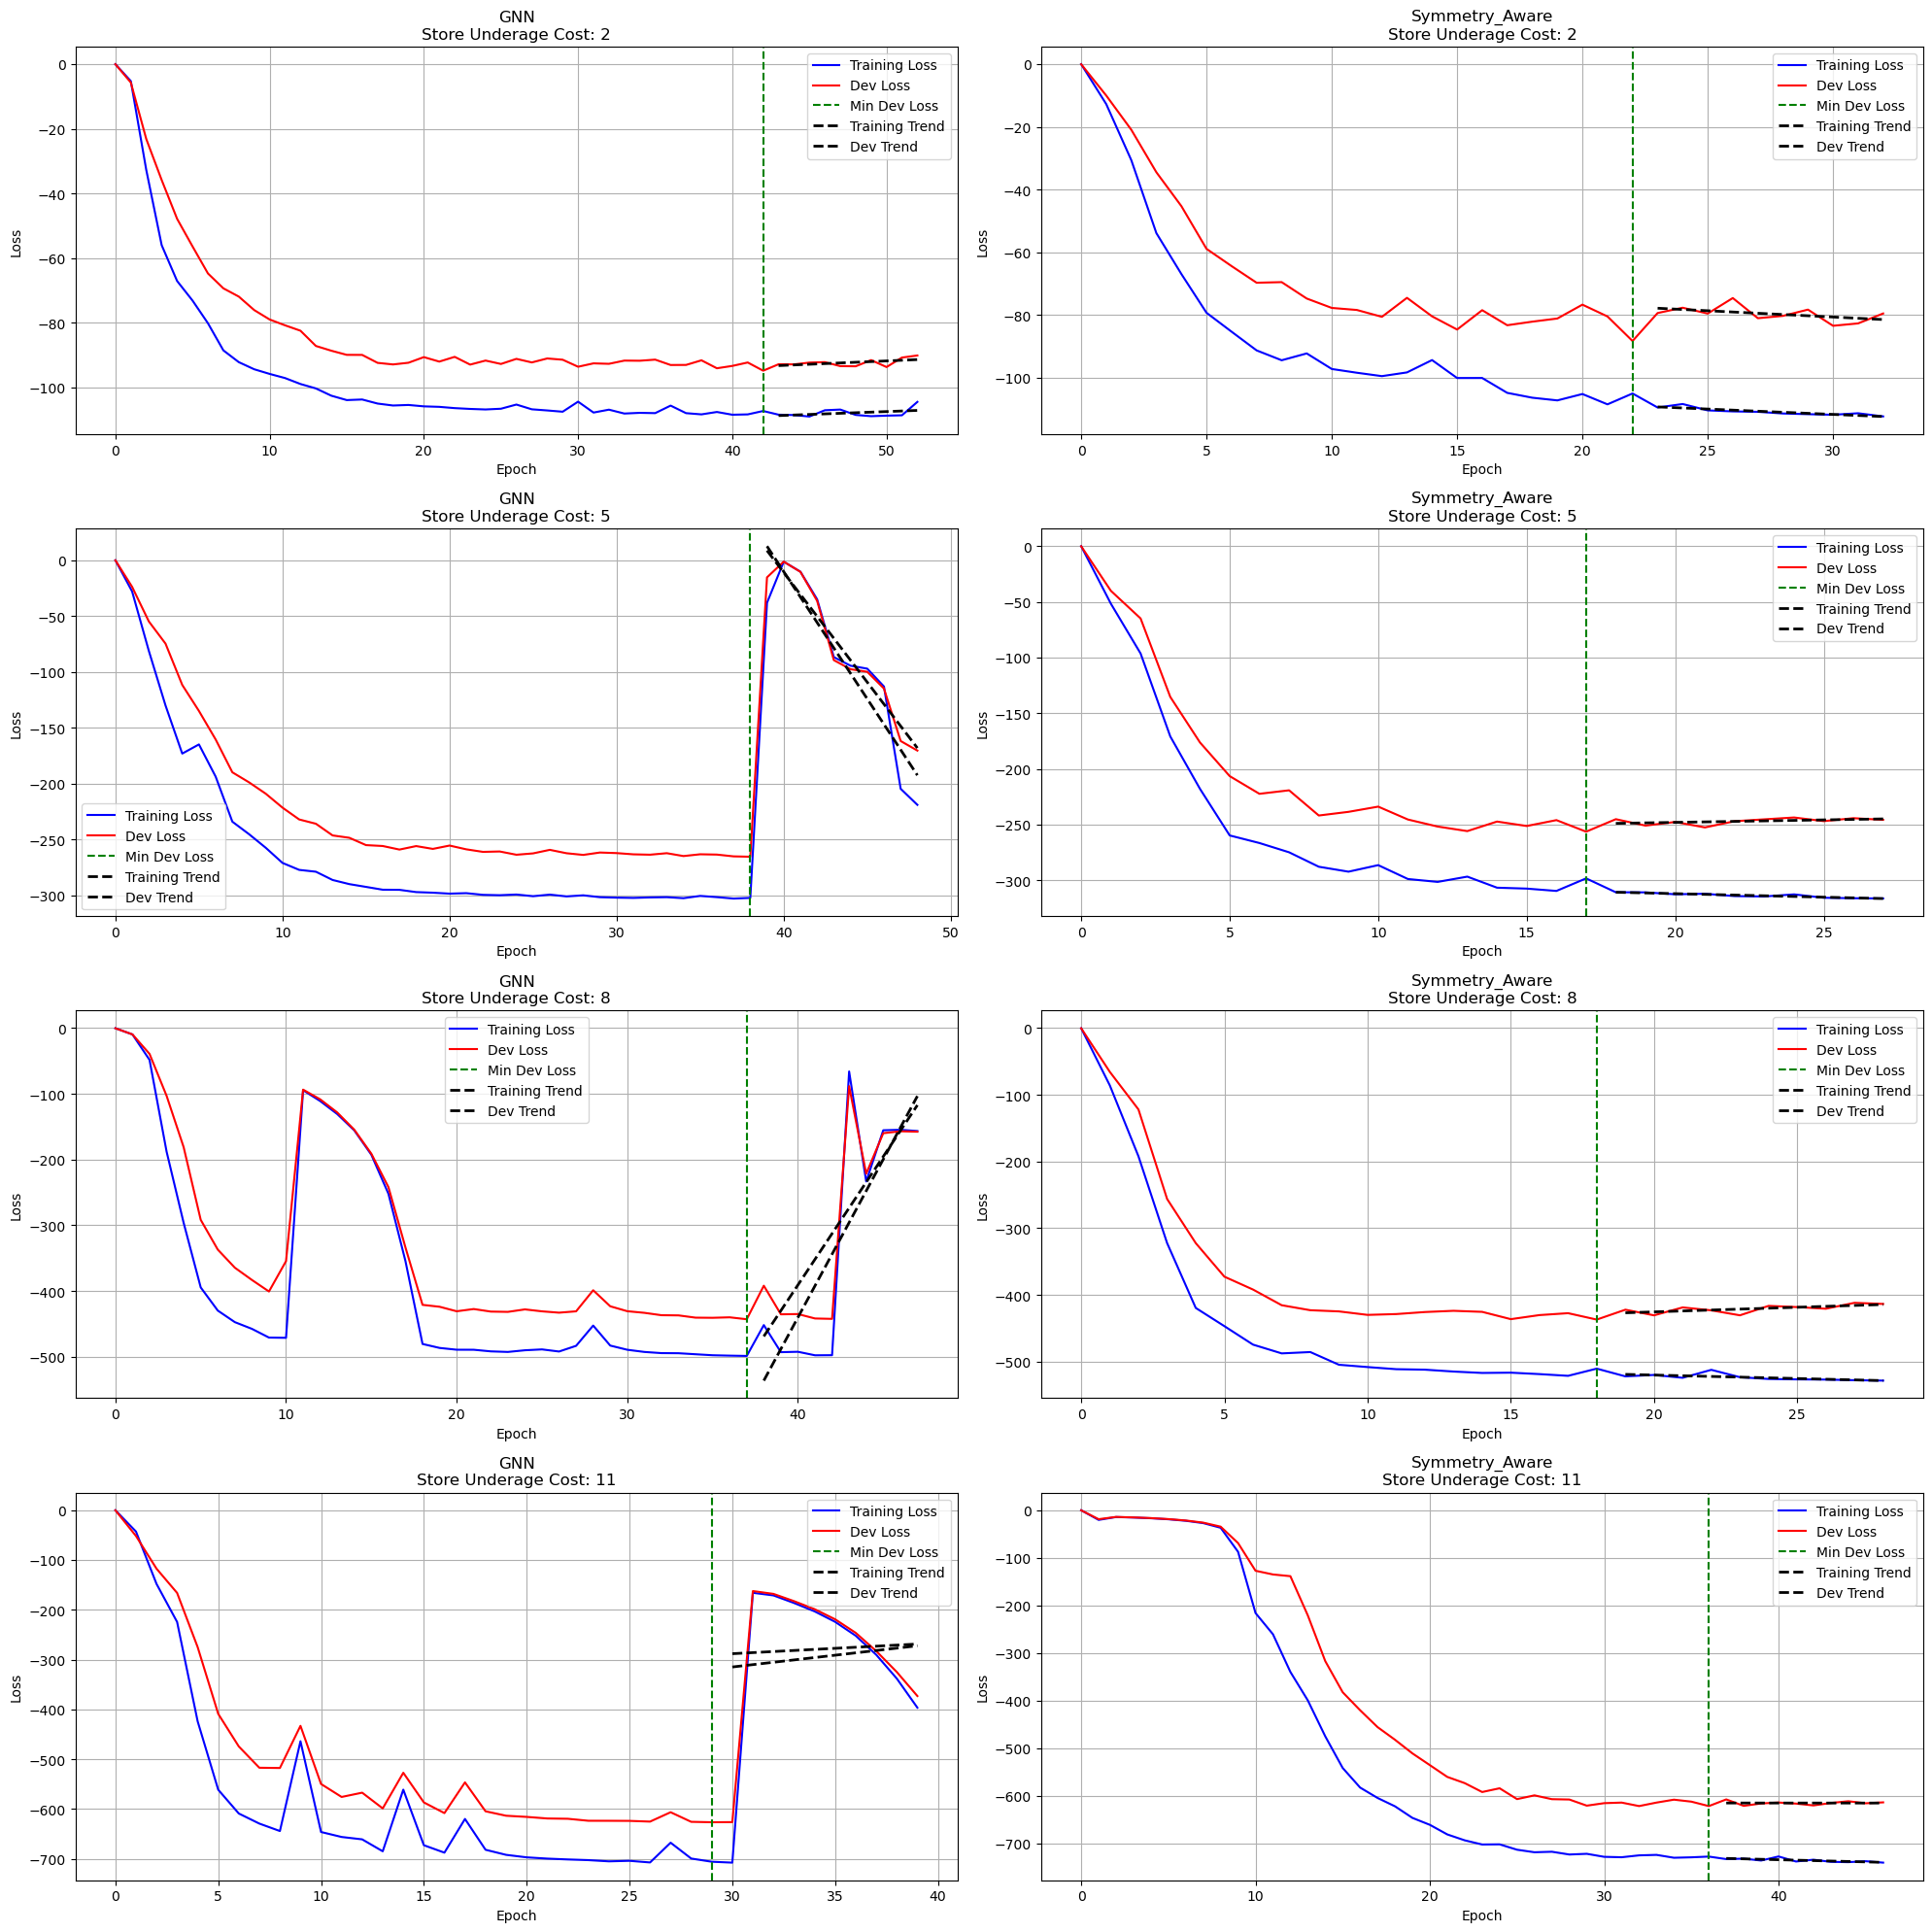

In [48]:
# Function to plot training curves for selected model
def plot_training_curves(store_underage_costs=[2,5,8,11], architecture_classes=['GNN', 'Symmetry_Aware']):
    fig, axes = plt.subplots(4, 2, figsize=(20, 20))
    
    for row_idx, store_underage_cost in enumerate(store_underage_costs):
        for col_idx, architecture_class in enumerate(architecture_classes):
            # Get the corresponding row from df_fixed
            selected_row = df[
                (df['store_underage_cost'] == store_underage_cost) & 
                (df['Architecture Class'] == architecture_class)
            ]
            
            if len(selected_row) == 0:
                print(f"No model found for {architecture_class}")
                continue
                
            # Get the path from the selected row
            model_path = selected_row['path'].iloc[0]
            progress_path = os.path.join(model_path, 'progress.csv')
            
            if not os.path.exists(progress_path):
                print(f"Progress file not found at {progress_path}")
                continue
                
            # Read and plot the training curves
            progress_df = pd.read_csv(progress_path)
            
            ax = axes[row_idx, col_idx]
            
            ax.plot(progress_df['train_loss'], label='Training Loss', color='blue')
            ax.plot(progress_df['dev_loss'], label='Dev Loss', color='red')
            
            # Add vertical line at minimum dev loss
            min_dev_epoch = progress_df['dev_loss'].idxmin()
            ax.axvline(x=min_dev_epoch, color='green', linestyle='--', label='Min Dev Loss')
            
            # Add trend lines based on last 10 points
            last_10_epochs = range(len(progress_df)-10, len(progress_df))
            train_z = np.polyfit(last_10_epochs, progress_df['train_loss'].iloc[-10:], 1)
            dev_z = np.polyfit(last_10_epochs, progress_df['dev_loss'].iloc[-10:], 1)
            train_p = np.poly1d(train_z)
            dev_p = np.poly1d(dev_z)
            
            ax.plot(last_10_epochs, train_p(last_10_epochs), '--', color='black', alpha=1.0, label='Training Trend', linewidth=2)
            ax.plot(last_10_epochs, dev_p(last_10_epochs), '--', color='black', alpha=1.0, label='Dev Trend', linewidth=2)
            
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Loss')
            ax.set_title(f'{architecture_class}\nStore Underage Cost: {store_underage_cost}')
            ax.legend()
            ax.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_curves()

In [49]:
def collect_data_and_plot(df, test_mode, setting_name, x_axis_value, n_stores):
    def run_main_run(row):
        try:
            cmd = [
                "/user/ml4723/.conda/envs/neural_inventory_control/bin/python",
                "main_run.py",
                test_mode, # test or test_on_dev
                setting_name,
                row['hyperparam_name'],
                row['path'],
                row['Architecture Class']
            ]
            env = {
                **os.environ,
                "MKL_THREADING_LAYER": "GNU",
                "MKL_SERVICE_FORCE_INTEL": "1"
            }
            subprocess.run(cmd, capture_output=True, text=True, check=True, env=env, cwd="/user/ml4723/Prj/NIC/")
        except subprocess.CalledProcessError as e:
            print(f"Error running main_run.py for path {row['path']}: {e}")
            print(f"Error output: {e.stderr}")
        except Exception as e:
            print(f"Unexpected error running main_run.py for path {row['path']}: {e}")

    def get_file_name(row):
        return f"results/one_warehouse_real/{n_stores}/{row['Architecture Class']}/{row['store_underage_cost']}.csv"
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        futures = []
        for _, row in df.iterrows():
            file_name = get_file_name(row)
            if os.path.exists(file_name):
                continue
            while len(futures) >= 8:
                done, not_done = concurrent.futures.wait(
                    futures, 
                    return_when=concurrent.futures.FIRST_COMPLETED
                )
                futures = list(not_done)
            futures.append(executor.submit(run_main_run, row))
        concurrent.futures.wait(futures)
    
    avg_s_underage = []
    avg_s_holding = []
    avg_w_holding = []
    avg_profit = []
    for _, row in df.iterrows():
        file_name = get_file_name(row)
        data = pd.read_csv(file_name)
        n_samples = 109
        batch_size = 109
        num_batches = n_samples // batch_size
        num_steps = 50
        start_step = 16
        
        relevant_indices = []
        for batch in range(num_batches):
            batch_start = batch * batch_size * num_steps
            step_start = batch_start + start_step * batch_size
            step_end = batch_start + num_steps * batch_size
            relevant_indices.extend(range(step_start, step_end))
        
        relevant_data = data.iloc[relevant_indices]
        
        avg_s_underage.append(-relevant_data['s_underage_costs'].mean() / row['store_underage_cost'])
        avg_s_holding.append(relevant_data['s_holding_costs'].mean() / row['store_underage_cost'])
        avg_w_holding.append(relevant_data['w_holding_costs'].mean() / row['store_underage_cost'])
        avg_profit.append(-relevant_data['s_underage_costs'].sum() * n_stores - relevant_data['s_holding_costs'].sum() * n_stores - relevant_data['w_holding_costs'].sum())

    df['avg_s_underage'] = avg_s_underage
    df['avg_s_holding'] = avg_s_holding
    df['avg_w_holding'] = avg_w_holding
    df['avg_profit'] = avg_profit

    # Calculate relative profit
    just_in_time_profits = df[df['Architecture Class'] == 'Just_In_Time'].set_index('store_underage_cost')['avg_profit']
    df['relative_profit'] = df.apply(lambda row: (row['avg_profit'] / just_in_time_profits[row['store_underage_cost']]) * 100, axis=1)

    plot_data = df.pivot(index=x_axis_value, columns='Architecture Class', 
                         values=['relative_profit', 'avg_s_underage', 'avg_s_holding', 'avg_w_holding'])
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easier iteration
    titles = ['Profit % relative to Just_In_Time', 'Store Revenue / (average unit underage cost)', 'Store Holding Cost / (average unit underage cost)', 'Warehouse Holding Cost / (average unit underage cost)']
    y_values = ['relative_profit', 'avg_s_underage', 'avg_s_holding', 'avg_w_holding']

    if x_axis_value == 'store_underage_cost':
        x_values = [2, 5, 8, 11]

    for i, (ax, title, y_value) in enumerate(zip(axes, titles, y_values)):
        for arch in df['Architecture Class'].unique():
            if arch == 'Just_In_Time':
                continue
            if arch in plot_data[y_value].columns:
                ax.plot(x_values, plot_data[y_value][arch].loc[x_values], marker='o', label=f'{arch}', 
                        color=color_scheme[arch], linestyle=linestyle_scheme[arch])
        
        ax.set_xlabel('Average unit underage cost')
        ax.set_ylabel(f'{title}')
        ax.set_title(title)
        ax.legend()
        ax.grid(True)
        ax.set_xticks(x_values)
        ax.set_xticklabels(x_values)
    
    plt.tight_layout()
    plt.show()
    return df


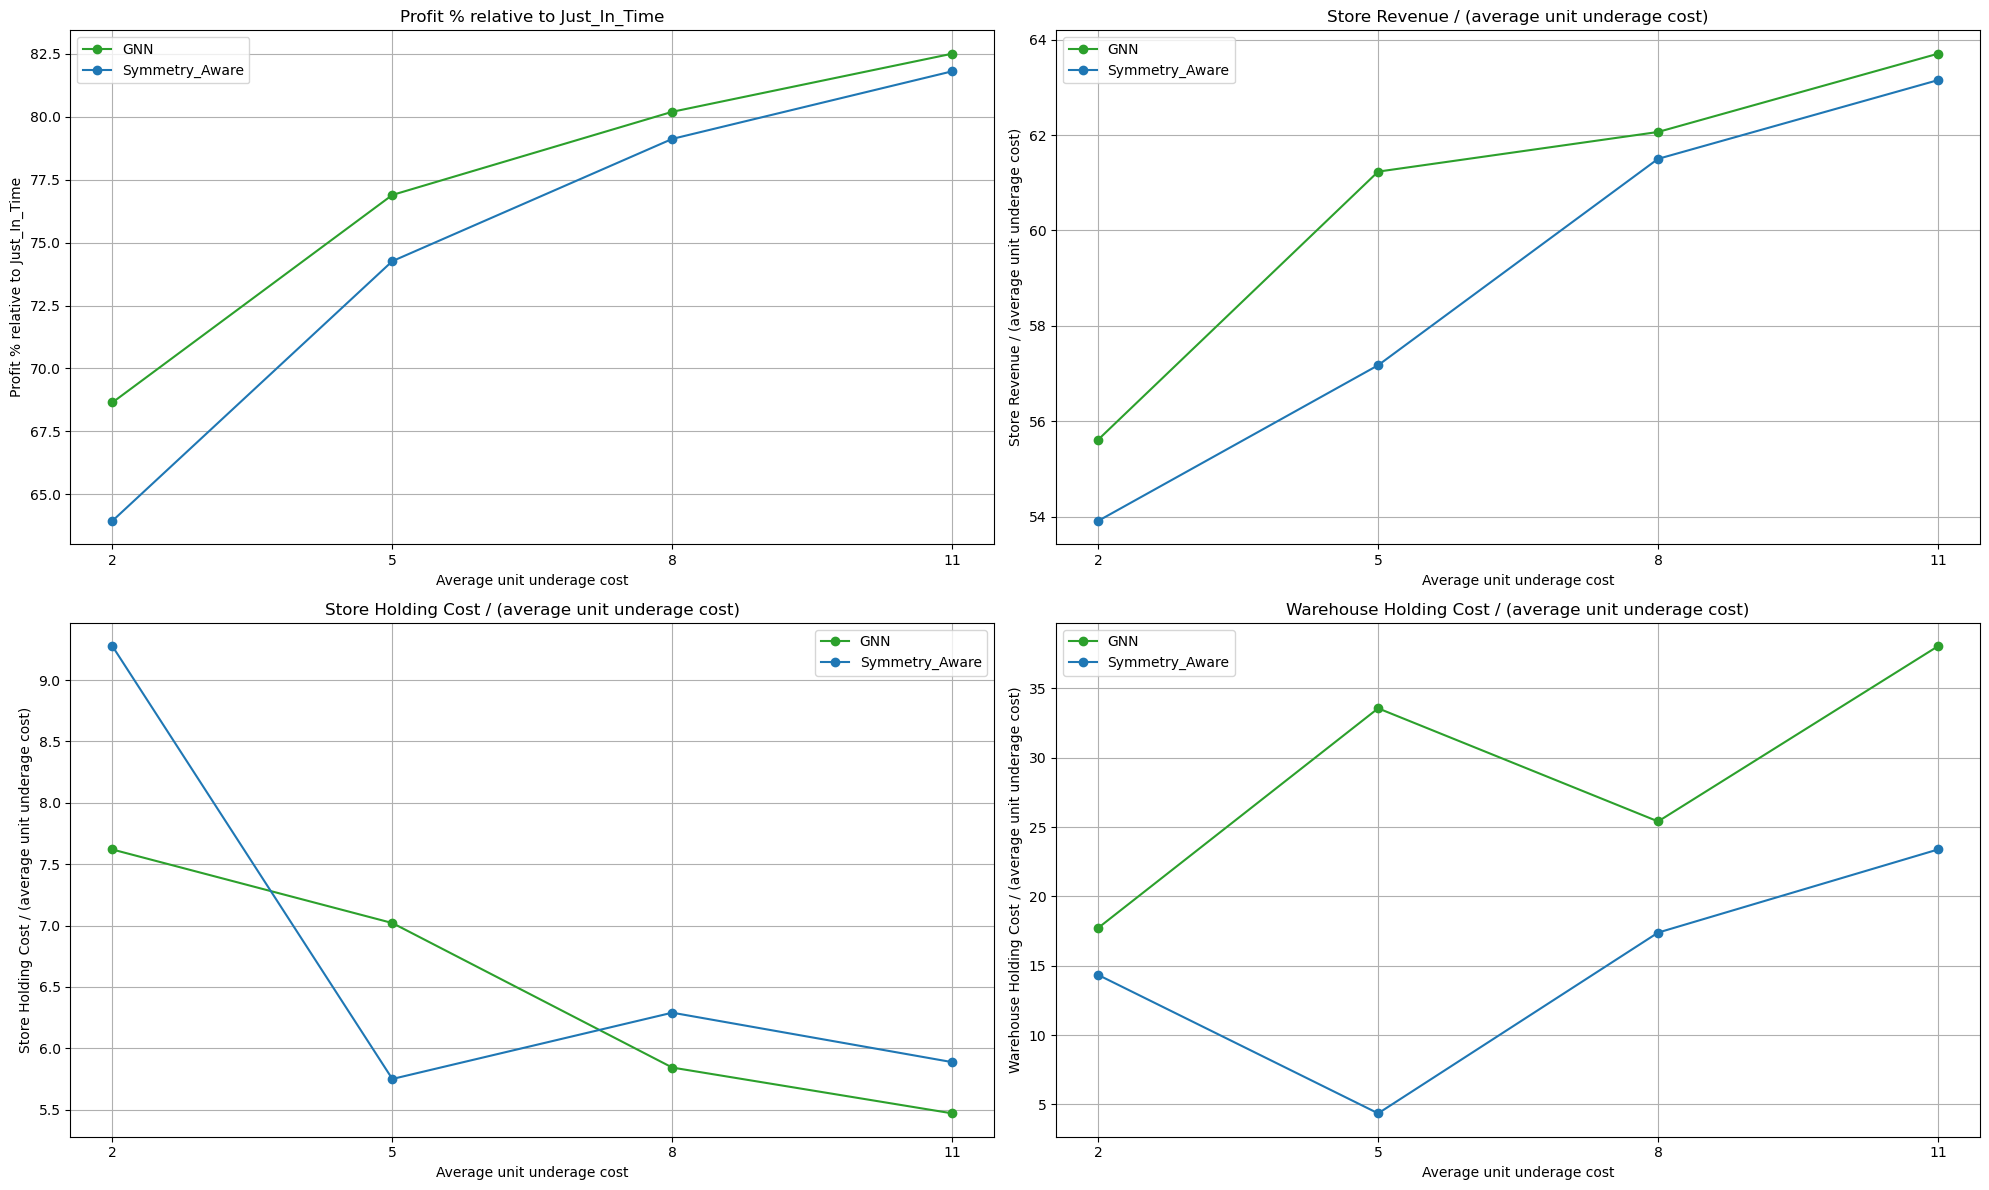

In [50]:
df_t = collect_data_and_plot(df, "test_on_dev", "one_warehouse_lost_demand_real", "store_underage_cost", n_stores)
